In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import pickle
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")  # Suppresses all warnings

In [2]:
# Read the data into a dataframe df
df = pd.read_csv(r"D:\LuxDev\ClassModels\train.csv")
df.head()

,credit_score,income,loan_amount,loan_term,interest_rate,debt_to_income_ratio,employment_years,savings_balance,age,default_risk_score
0,810,107410,11924,48,7.97,43.29,32,27181,58,7634.543366
1,418,37482,19291,24,6.94,11.01,33,15089,43,6249.833059
2,724,85641,39501,36,8.59,37.11,0,97459,33,2148.117990
3,444,73331,25714,36,13.09,33.39,18,2413,48,4979.385344
4,440,46723,35651,36,8.30,46.21,6,9716,42,2993.851950


In [3]:
# Checking key statistical summaries for our target feature
df['default_risk_score'].describe()

count     800.000000
mean     4529.968687
std      2567.048232
min        49.757940
25%      2377.592064
50%      4379.666025
75%      6821.026905
max      9113.843128
Name: default_risk_score, dtype: float64

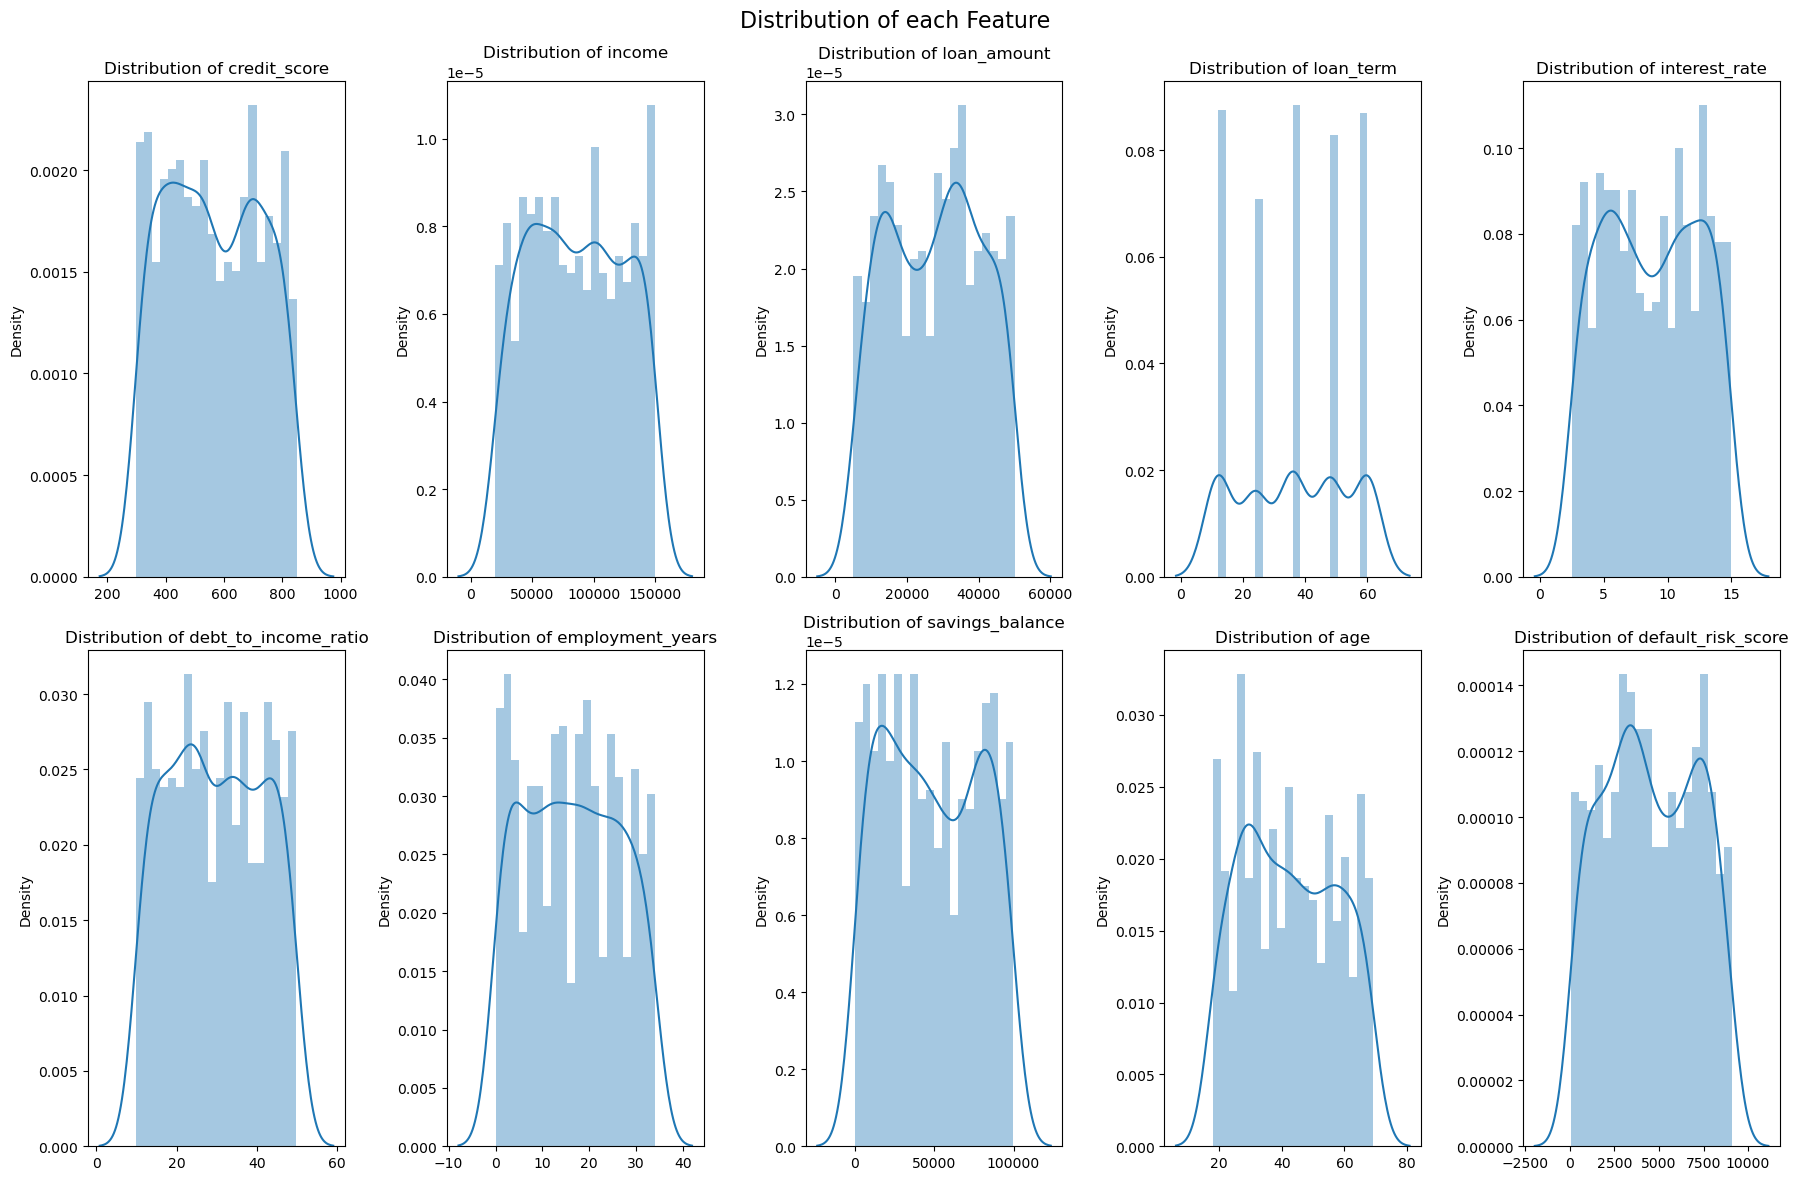

In [4]:
# Set the axes for a feature plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 12))
axes = axes.flatten()
# Plot each features distribution
for i, column in enumerate(df.columns):
    sns.distplot(df[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel("")
plt.suptitle("Distribution of each Feature", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

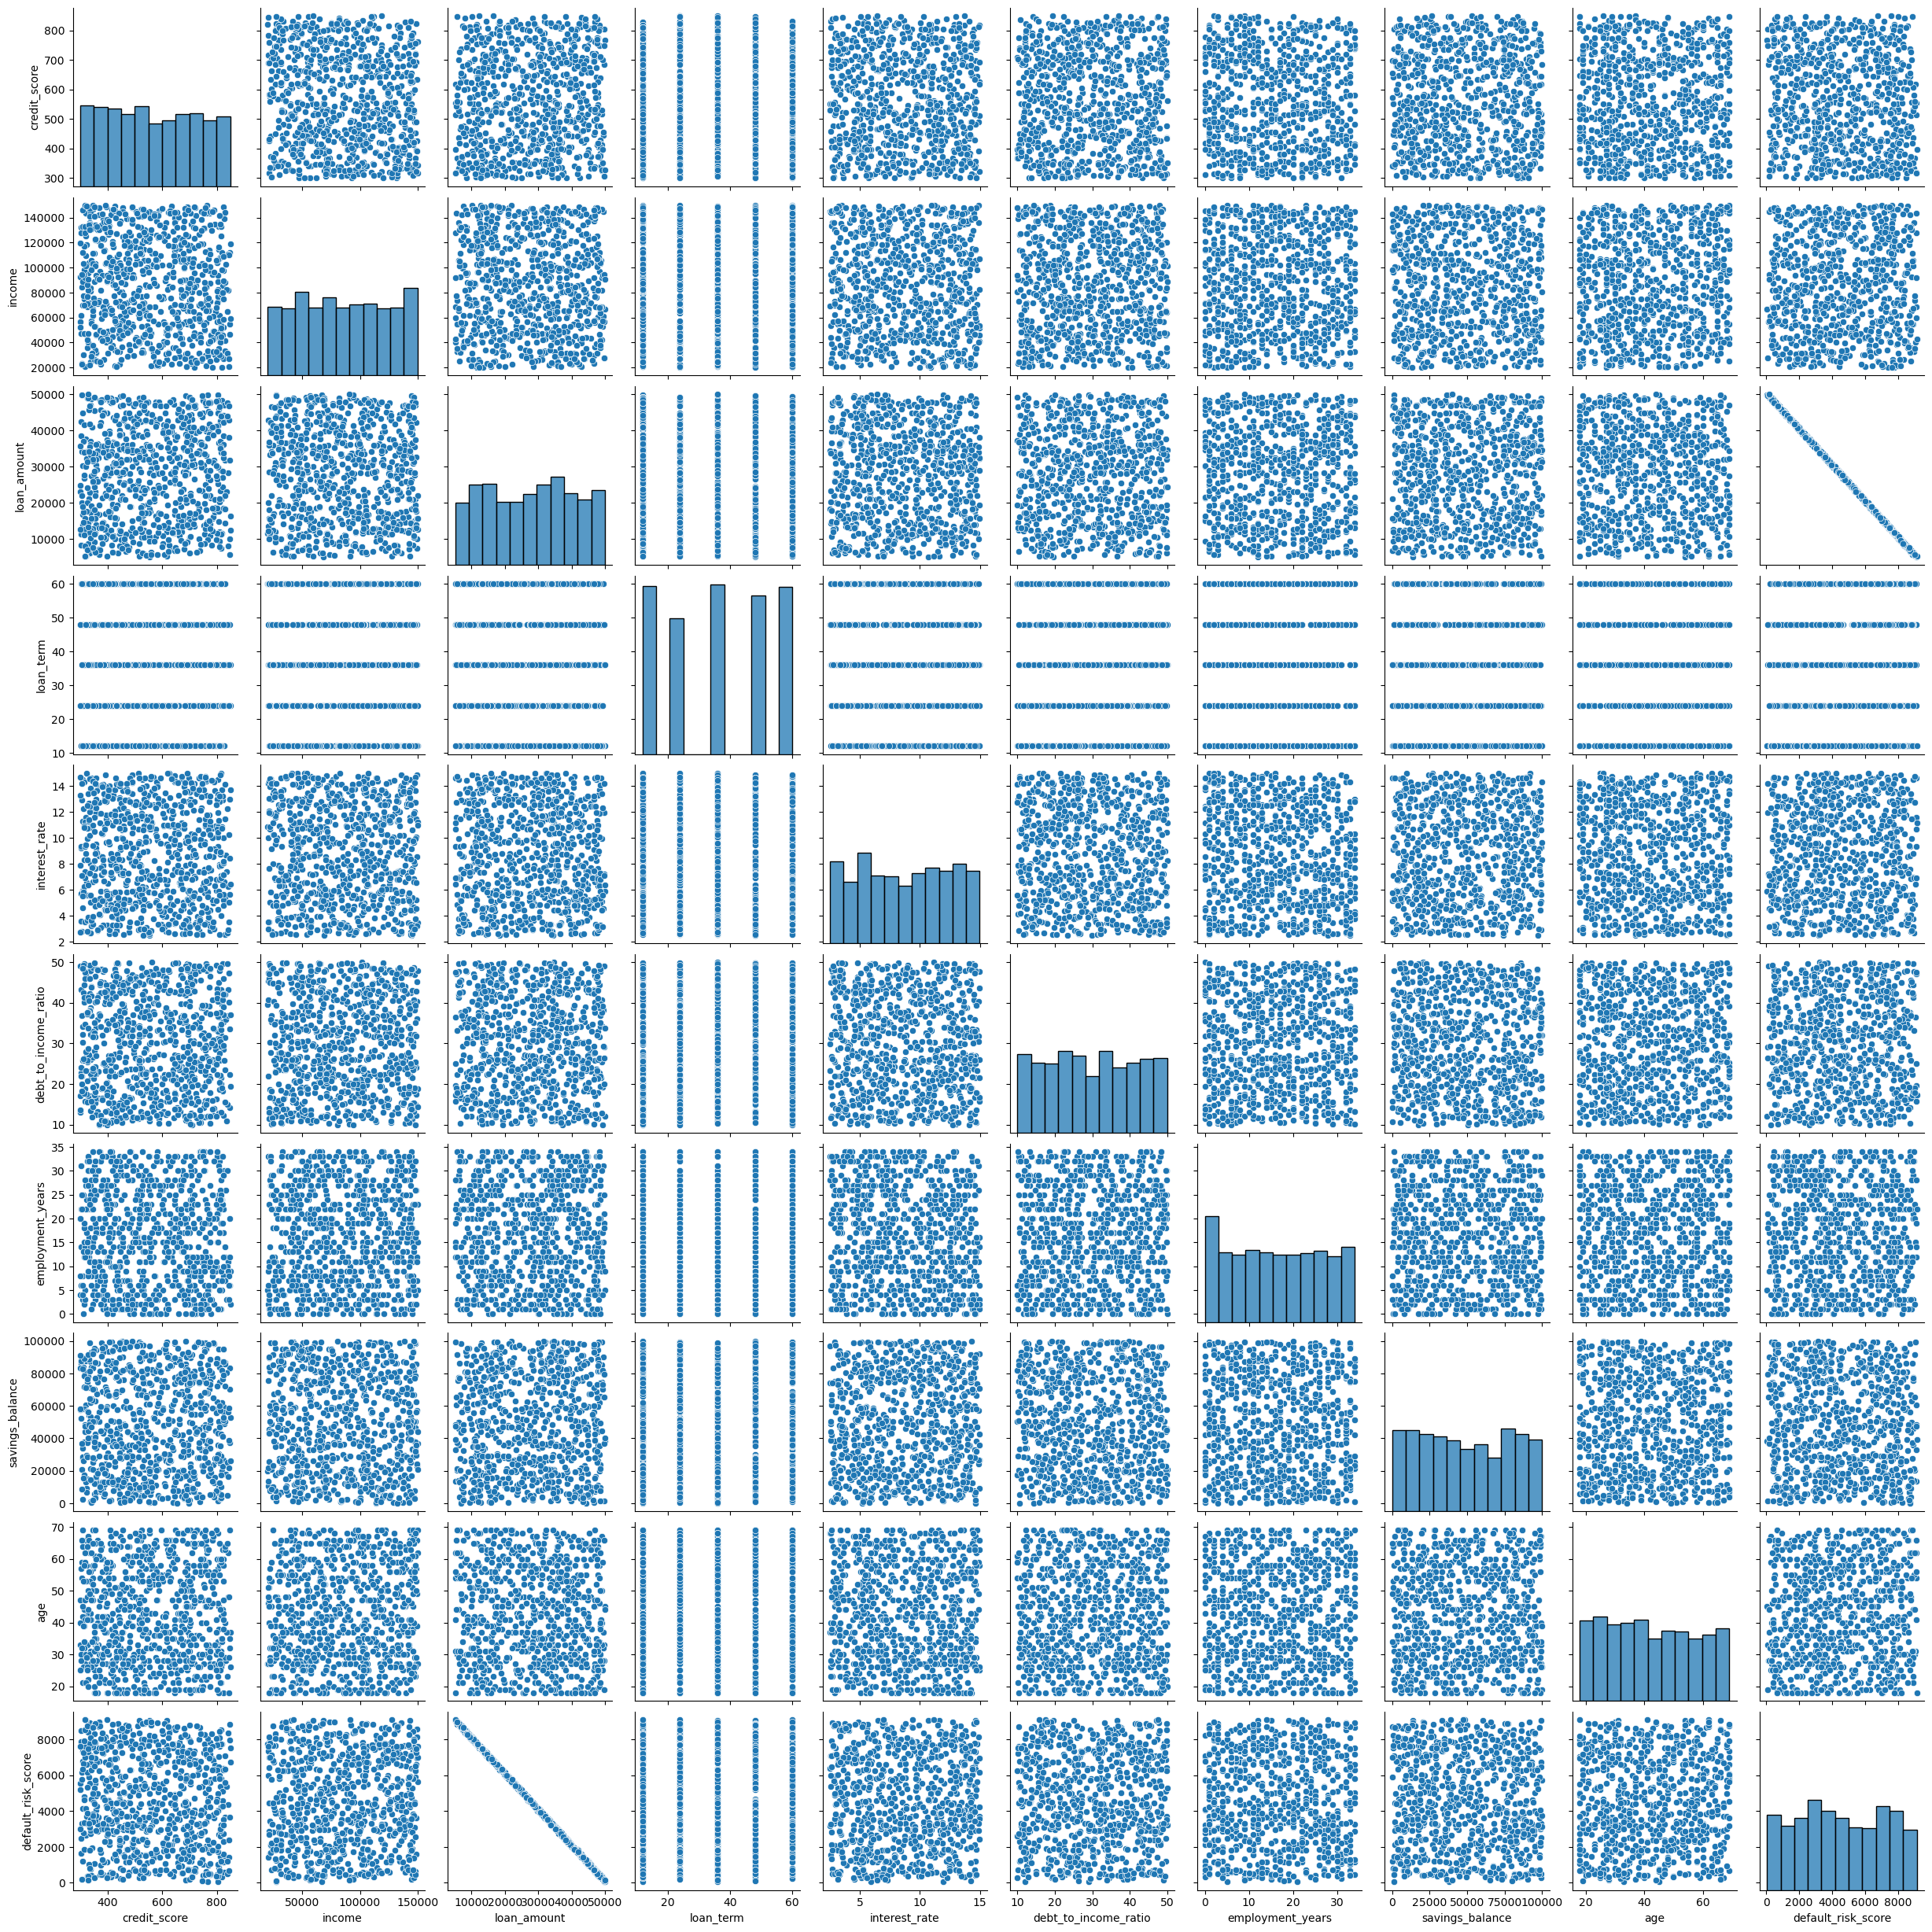

In [5]:
# Plot a pairplot to show distributions within the dataset
sns.pairplot(df);

In [6]:
# Split the data
target = "default_risk_score"
X = df.drop(columns=[target])
y = df[target]

In [7]:
# Add constant column to X
X_const = sm.add_constant(X)  # Correctly adds an intercept term

# Fit OLS model with X_const (not X)
model = sm.OLS(y, X_const).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     default_risk_score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.272e+06
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:02:01   Log-Likelihood:                -3013.8
No. Observations:                 800   AIC:                             6048.
Df Residuals:                     790   BIC:                             6095.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.026e+04 

#### We are going to do succesive VIF(Variance Inflation Factor) test
- This test confirm which feature has a higher rate(>10)
- We then drop that feature since it is causing multicoleanearity in the dataset.

In [9]:
# Add constant column to X.
X_const = sm.add_constant(X)  # Add constant column
df_vif = pd.DataFrame()
df_vif["feature"] = X_const.columns  # Use X_const columns
df_vif["VIF"] = [variance_inflation_factor
                 (X_const.values, i) for i in range(X_const.shape[1])]

print(df_vif)

                feature        VIF
0                 const  53.786900
1          credit_score   1.014323
2                income   1.015175
3           loan_amount   1.011773
4             loan_term   1.005604
5         interest_rate   1.015253
6  debt_to_income_ratio   1.009519
7      employment_years   1.007945
8       savings_balance   1.012595
9                   age   1.008272


In [10]:
# X= X.drop(columns= ['const'], axis=1)

In [11]:
# Do a second check on VIF test without adding a constant
df_vif1 = pd.DataFrame()
df_vif1["feature"] = X.columns  # Use X_const columns
df_vif1["VIF"] = [variance_inflation_factor
                  (X.values, i) for i in range(X.shape[1])]

print(df_vif1)

                feature        VIF
0          credit_score  10.447391
1                income   5.534650
2           loan_amount   5.292960
3             loan_term   5.139920
4         interest_rate   5.883418
5  debt_to_income_ratio   6.729297
6      employment_years   3.449460
7       savings_balance   3.567017
8                   age   8.017349


In [12]:
# Drop credit score(has highest VIF>10)
X = X.drop(columns=['credit_score'], axis=1)

In [13]:
# Do a third VIF test after dropping credit score
df_vif2 = pd.DataFrame()
df_vif2["feature"] = X.columns  # Use X_const columns
df_vif2["VIF"] = [variance_inflation_factor
                  (X.values, i) for i in range(X.shape[1])]

print(df_vif2)

                feature       VIF
0                income  5.485923
1           loan_amount  4.943911
2             loan_term  5.014842
3         interest_rate  5.621171
4  debt_to_income_ratio  6.467657
5      employment_years  3.400337
6       savings_balance  3.523232
7                   age  7.528226


In [14]:
# The remaining features are within acceptable VIF range.
X = df[df_vif2["feature"]]
X.head()

,income,loan_amount,loan_term,interest_rate,debt_to_income_ratio,employment_years,savings_balance,age
0,107410,11924,48,7.97,43.29,32,27181,58
1,37482,19291,24,6.94,11.01,33,15089,43
2,85641,39501,36,8.59,37.11,0,97459,33
3,73331,25714,36,13.09,33.39,18,2413,48
4,46723,35651,36,8.30,46.21,6,9716,42


In [15]:
# Carry out the train_test_split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [16]:
# Standard scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Training 3 selected models then picking the best perfroming model
# Ridge regression with GridSearchCV
ridge = Ridge()
params = {"alpha": [0.1, 1, 10, 100]}

grid_search = GridSearchCV(
    ridge, params, scoring="neg_mean_squared_error", cv=5
)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print("Best cross-validation MSE: ", -grid_search.best_score_)
# Fit the model with best alpha
ridge_best = Ridge(alpha=grid_search.best_params_["alpha"])
ridge_best.fit(X_train, y_train)

# Apply Random Forest regressor
param_grid_rf = {"n_estimators": [100, 200], "max_depth": [None, 10, 20]}
rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(
    rf, param_grid_rf, scoring="neg_mean_squared_error", cv=5
)
grid_search_rf.fit(X_train, y_train)
print(f"Best Params for RandomForest: {grid_search_rf.best_params_}")
rf_best = RandomForestRegressor(**grid_search_rf.best_params_)
rf_best.fit(X_train, y_train)

# Gradient Boosting Regressor with GridSearchCV
param_grid_gb = {
    "n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]
}
gb = GradientBoostingRegressor()
grid_search_gb = GridSearchCV(
    gb, param_grid_gb, scoring="neg_mean_squared_error", cv=5
)
grid_search_gb.fit(X_train, y_train)
print(f"Best Params for GradientBoosting: {grid_search_gb.best_params_}")

# Fit the best params
gb_best = GradientBoostingRegressor(**grid_search_gb.best_params_)
gb_best.fit(X_train, y_train)

# Model evaluation
models = {
    "Ridge": ridge_best, "RandomForest": rf_best, "GradientBoosting": gb_best
}
# Doing a for loop to extract the respective metric scores
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print()
    print(f"{name} Model Performance:")
    print(f" MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print("-"*40)

Best Parameters: {'alpha': 0.1}
Best cross-validation MSE:  2556.9953797356193
Best Params for RandomForest: {'max_depth': 20, 'n_estimators': 200}
Best Params for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Ridge Model Performance:
 MSE: 2219.73
RMSE: 47.11
R2 Score: 1.00
----------------------------------------

RandomForest Model Performance:
 MSE: 3013.70
RMSE: 54.90
R2 Score: 1.00
----------------------------------------

GradientBoosting Model Performance:
 MSE: 3331.08
RMSE: 57.72
R2 Score: 1.00
----------------------------------------


In [18]:
# Getting the best model
best_model = min(
    models.items(),
    key=lambda x: mean_squared_error(y_test, x[1].predict(X_test)))[1]

In [19]:
# Print the best model
best_model

Ridge(alpha=0.1)

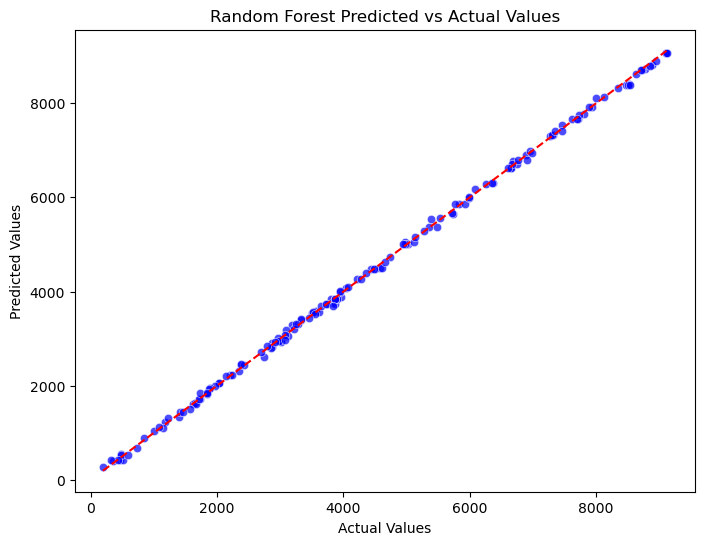

In [20]:
# We are plotting a scatter plot for Predicted vs Actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="blue")

# Add a reference line (y = x) for perfect predictions
plt.plot(
    [min(y_test), max(y_test)], [min(y_test), max(y_test)],
    color="red", linestyle="--"
)

# Append Labels and Title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Predicted vs Actual Values")

# Show plot
plt.show()

In [21]:
# Save the trained Random Forest model
with open("rf_best.pkl", "wb") as file:
    pickle.dump(rf_best, file)

In [22]:
# Save the trained Gradient Bosting model
with open("gb_best.pkl", "wb") as file:
    pickle.dump(gb_best, file)

In [23]:
# Save the trained Ridge model
with open("ridge_best.pkl", "wb") as file:
    pickle.dump(ridge_best, file)

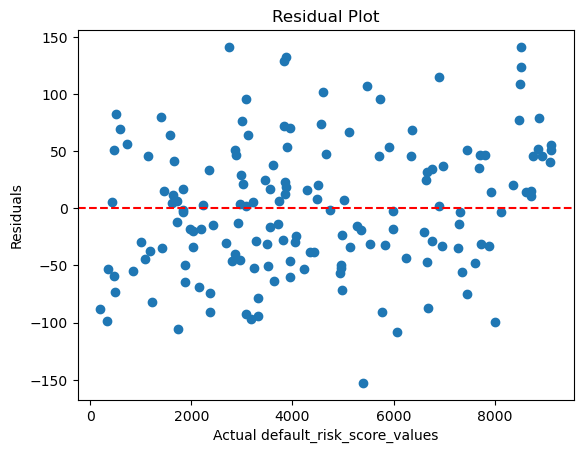

In [24]:
# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual default_risk_score_values")
plt.ylabel("Residuals")
plt.title("Residual Plot");